In [1]:
from pytorch_lightning import seed_everything
from scripts.demo.streamlit_helpers import *

SD_XL_BASE_RATIOS = {
    "0.5": (704, 1408),
    "0.52": (704, 1344),
    "0.57": (768, 1344),
    "0.6": (768, 1280),
    "0.68": (832, 1216),
    "0.72": (832, 1152),
    "0.78": (896, 1152),
    "0.82": (896, 1088),
    "0.88": (960, 1088),
    "0.94": (960, 1024),
    "1.0": (1024, 1024),
    "1.07": (1024, 960),
    "1.13": (1088, 960),
    "1.21": (1088, 896),
    "1.29": (1152, 896),
    "1.38": (1152, 832),
    "1.46": (1216, 832),
    "1.67": (1280, 768),
    "1.75": (1344, 768),
    "1.91": (1344, 704),
    "2.0": (1408, 704),
    "2.09": (1472, 704),
    "2.4": (1536, 640),
    "2.5": (1600, 640),
    "2.89": (1664, 576),
    "3.0": (1728, 576),
}

VERSION2SPECS = {
    "SDXL-base-1.0": {
        "H": 1024,
        "W": 1024,
        "C": 4,
        "f": 8,
        "is_legacy": False,
        "config": "configs/inference/sd_xl_base.yaml",
        "ckpt": "checkpoints/sd_xl_base_1.0.safetensors",
    },
    "SDXL-refiner-1.0": {
        "H": 1024,
        "W": 1024,
        "C": 4,
        "f": 8,
        "is_legacy": True,
        "config": "configs/inference/sd_xl_refiner.yaml",
        "ckpt": "checkpoints/sd_xl_refiner_1.0.safetensors",
    },
}


def load_img(display=True, key=None, device="cuda"):
    image = get_interactive_image(key=key)
    if image is None:
        return None
    if display:
        st.image(image)
    w, h = image.size
    print(f"loaded input image of size ({w}, {h})")
    width, height = map(
        lambda x: x - x % 64, (w, h)
    )  # resize to integer multiple of 64
    image = image.resize((width, height))
    image = np.array(image.convert("RGB"))
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0
    return image.to(device)


def run_txt2img(
    state,
    version,
    version_dict,
    is_legacy=False,
    return_latents=False,
    filter=None,
    stage2strength=None,
):
    # SD_XL_BASE_RATIOS.values()
    W, H = 1024, 1024
    C = version_dict["C"]
    F = version_dict["f"]

    init_dict = {
        "orig_width": W,
        "orig_height": H,
        "target_width": W,
        "target_height": H,
    }
    value_dict = init_embedder_options(
        get_unique_embedder_keys_from_conditioner(state["model"].conditioner),
        init_dict,
        prompt=prompt,
        negative_prompt=negative_prompt,
    )
    sampler, num_rows, num_cols = init_sampling(stage2strength=stage2strength)
    num_samples = num_rows * num_cols

    out = do_sample(
        state["model"],
        sampler,
        value_dict,
        num_samples,
        H,
        W,
        C,
        F,
        force_uc_zero_embeddings=["txt"] if not is_legacy else [],
        return_latents=return_latents,
        filter=filter,
    )
    return out


def run_img2img(
    state,
    version_dict,
    is_legacy=False,
    return_latents=False,
    filter=None,
    stage2strength=None,
):
    img = load_img()
    if img is None:
        return None
    H, W = img.shape[2], img.shape[3]

    init_dict = {
        "orig_width": W,
        "orig_height": H,
        "target_width": W,
        "target_height": H,
    }
    value_dict = init_embedder_options(
        get_unique_embedder_keys_from_conditioner(state["model"].conditioner),
        init_dict,
        prompt=prompt,
        negative_prompt=negative_prompt,
    )
    strength = 0.75  # 0 to 1
    sampler, num_rows, num_cols = init_sampling(
        img2img_strength=strength,
        stage2strength=stage2strength,
    )
    num_samples = num_rows * num_cols
    out = do_img2img(
        repeat(img, "1 ... -> n ...", n=num_samples),
        state["model"],
        sampler,
        value_dict,
        num_samples,
        force_uc_zero_embeddings=["txt"] if not is_legacy else [],
        return_latents=return_latents,
        filter=filter,
    )
    return out


def apply_refiner(
    input,
    state,
    sampler,
    num_samples,
    prompt,
    negative_prompt,
    filter=None,
    finish_denoising=False,
):
    init_dict = {
        "orig_width": input.shape[3] * 8,
        "orig_height": input.shape[2] * 8,
        "target_width": input.shape[3] * 8,
        "target_height": input.shape[2] * 8,
    }

    value_dict = init_dict
    value_dict["prompt"] = prompt
    value_dict["negative_prompt"] = negative_prompt

    value_dict["crop_coords_top"] = 0
    value_dict["crop_coords_left"] = 0

    value_dict["aesthetic_score"] = 6.0
    value_dict["negative_aesthetic_score"] = 2.5

    st.warning(f"refiner input shape: {input.shape}")
    samples = do_img2img(
        input,
        state["model"],
        sampler,
        value_dict,
        num_samples,
        skip_encode=True,
        filter=filter,
        add_noise=not finish_denoising,
    )

    return samples

In [7]:
version = "SDXL-base-1.0"
version_dict = VERSION2SPECS[version]
mode = "txt2img"

state = init_st(version_dict, load_filter=True)

2023-07-27 07:05:25.852 
  command:

    streamlit run /home/aniket/miniconda3/envs/sd/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]


Building a Downsample layer with 2 dims.
  --> settings are: 
 in-chn: 320, out-chn: 320, kernel-size: 3, stride: 2, padding: 1
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 2048 and using 10 heads with a dimension of 64.
BasicTransformerBlock is using checkpointing
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 2048 and using 10 heads with a dimension of 64.
BasicTransformerBlock is using checkpointing
constructing SpatialTransformer of depth 2 w/ 640 channels and 10 heads
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads with a dimension of 64.
Setting up MemoryEffici

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.23.self_attn.q_proj.bias', 'vision_model.encoder.layers.23.self_attn.v_proj.bias', 'vision_model.encoder.layers.22.mlp.fc2.bias', 'vision_model.encoder.layers.8.self_attn.q_proj.weight', 'vision_model.encoder.layers.13.layer_norm2.bias', 'vision_model.encoder.layers.2.mlp.fc2.bias', 'vision_model.encoder.layers.6.mlp.fc1.bias', 'vision_model.encoder.layers.19.self_attn.v_proj.bias', 'vision_model.encoder.layers.3.mlp.fc1.bias', 'vision_model.encoder.layers.6.self_attn.out_proj.weight', 'vision_model.encoder.layers.1.mlp.fc2.bias', 'vision_model.encoder.layers.13.layer_norm1.bias', 'vision_model.encoder.layers.2.self_attn.q_proj.weight', 'vision_model.encoder.layers.19.mlp.fc1.weight', 'vision_model.encoder.layers.16.layer_norm2.bias', 'vision_model.encoder.layers.7.self_attn.k_proj.bias', 'vision_model.encoder.layers.20.mlp.fc1.weight', 'vis

Initialized embedder #0: FrozenCLIPEmbedder with 123060480 params. Trainable: False


In [2]:
is_legacy = False
add_pipeline = False
stage2strength=False
negative_prompt=""

In [ ]:
# prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
prompt = "Llama in a jungle, Lightning, AI themed, purple colors, detailed, 8k"

In [6]:
out = run_txt2img(
            state,
            version,
            version_dict,
            is_legacy=is_legacy,
            return_latents=add_pipeline,
            filter=state.get("filter"),
            stage2strength=stage2strength,
        )

NameError: name 'state' is not defined

In [59]:
samples, samples_z = out, None
if isinstance(out, (tuple, list)):
    samples, samples_z = out

In [60]:
from PIL import Image

In [61]:
images = []
for sample in samples:
    sample = 255.0 * rearrange(sample.cpu().numpy(), "c h w -> h w c")
    image = Image.fromarray(sample.astype(np.uint8))
    images.append(image)

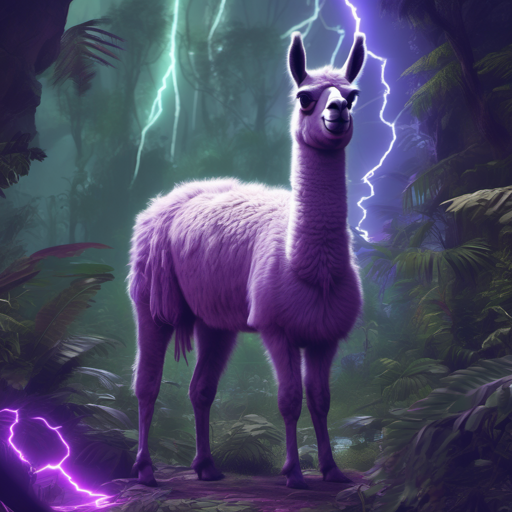

In [62]:
images[0].resize((512,512))